In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
cd '/content/gdrive/My Drive/VIP_Project/MNIST'

/content/gdrive/My Drive/VIP_Project/MNIST


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [4]:
num_epoch = 100
batch_size = 1000 #50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

# prepare data
data = np.load("moving-mnist-2-tr-images.npy" )

# training set
x_tr = data[0:10000, in_timesteps,  :, :]
y_tr = data[0:10000, out_timesteps, :, :]
x_tr = x_tr.reshape(x_tr.shape[0], len(in_timesteps),  64, 64, 1)
y_tr = y_tr.reshape(y_tr.shape[0], len(out_timesteps), 64, 64, 1)
tr_set = data[0:10000, :, :, :]

# validation set
x_te = data[10000:, in_timesteps,  :, :]
y_te = data[10000:, out_timesteps, :, :]
x_te = x_te.reshape(x_te.shape[0], len(in_timesteps),  64, 64, 1)
y_te = y_te.reshape(y_te.shape[0], len(out_timesteps), 64, 64, 1)
te_set = data[10000:, :, :, :]

print (np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te))

(10000, 19, 64, 64, 1) (10000, 19, 64, 64, 1) (1000, 19, 64, 64, 1) (1000, 19, 64, 64, 1)


In [5]:
from keras.models import Sequential, Model
from keras.layers import Input, Add, Conv2D, Conv3D, Concatenate, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed

def mainmodel():
  # Inputs
  dtype='float32'  
  contentInput = Input(shape=(None, 64, 64, 1), dtype=dtype)

  #Encoding Network
  x1 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(contentInput)
  x2 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1) 
  x3 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2) 

  #Forecasting Network
  x4 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1)
  x5 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2)
  x6 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x3)

  #Prediction Network
  conc = Concatenate()([x4, x5, x6]) #
  predictions = Conv3D(1, (5,5,5), activation='sigmoid', padding='same')(conc) #sigmoid original

  model = Model(inputs=contentInput, outputs=predictions)
  
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [6]:
seq = mainmodel()
seq.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, None, 64, 64, 1651712     input_1[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, None, 64, 64, 1229056     conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, None, 64, 64, 819456      conv_lst_m2d_1[0][0]             
_______________________________________________________________________________________

In [7]:
# ConvLSTM modified
# #Build a model
# seq = keras.Sequential(
#     [
#         keras.Input(
#             shape=(None, 64, 64, 1)
#         ),  # Variable-length sequence of 40x40x1 frames
#         layers.ConvLSTM2D(
#             filters=16, kernel_size=(3, 3), padding="same", return_sequences=True
#         ),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(
#             filters=24, kernel_size=(3, 3), padding="same", return_sequences=True
#         ),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(
#             filters=32, kernel_size=(3, 3), padding="same", return_sequences=True
#         ),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(
#             filters=32, kernel_size=(3, 3), padding="same", return_sequences=True
#         ),
#         layers.BatchNormalization(),
#         layers.Conv3D(
#             filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
#         ),
#     ]
# )
# seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [7]:
def generator(X, y, batch_size):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            yield np.array(X[start:end]/255), np.array(y[start:end]/255)

In [8]:
#seq.save('conv_lstm_checkpoint_generator') #Epoch 40
#seq = keras.models.load_model('conv_lstm_checkpoint_generator') #Epoch 40
#seq.save('conv_lstm_checkpoint_generator') #Epoch 40
seq.load_weights('conv_lstm_en_de_checkpoint2') #Epoch 1
seq.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, None, 64, 64, 1651712     input_1[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, None, 64, 64, 1229056     conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, None, 64, 64, 819456      conv_lst_m2d_1[0][0]             
_______________________________________________________________________________________

In [ ]:
batch_size=4

checkpoint_filepath = 'conv_lstm_en_de_checkpoint2_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
  )

seq.fit_generator(
    generator(x_tr, y_tr, batch_size),
    steps_per_epoch = len(x_tr)/batch_size,
    epochs=1,
    verbose=1,
    validation_data = generator(x_te, y_te, batch_size),
    validation_steps = len(x_te)/batch_size,
    callbacks=[model_checkpoint_callback]
)

1907/2500 [=====================>........] - ETA: 2:12:32 - loss: 0.0256

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


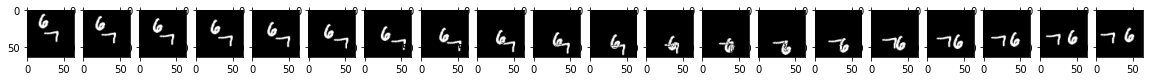

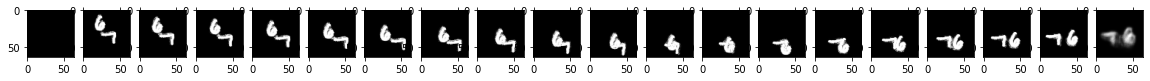

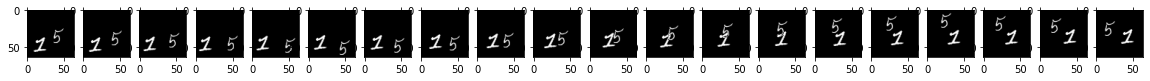

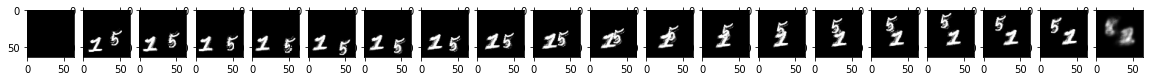

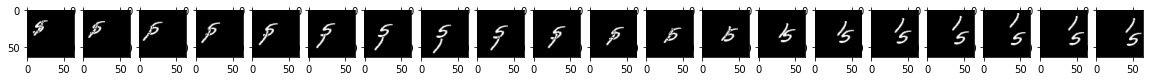

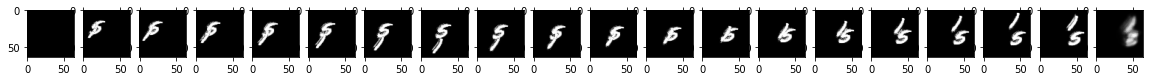

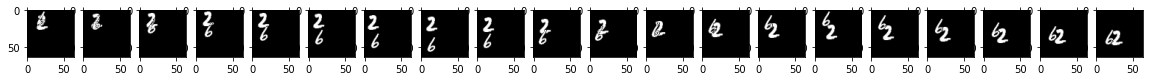

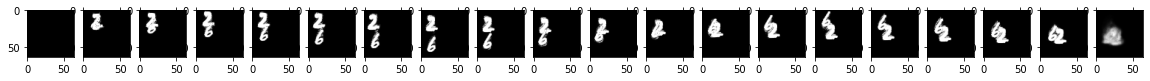

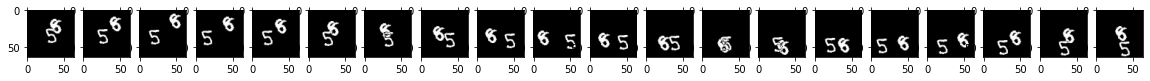

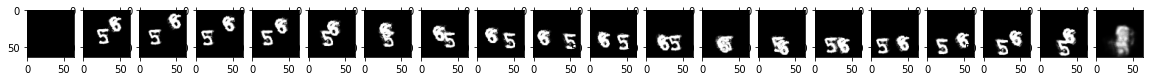

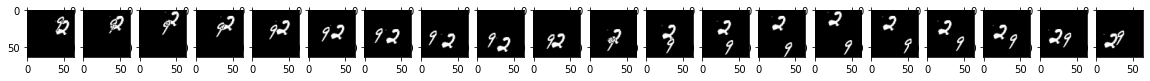

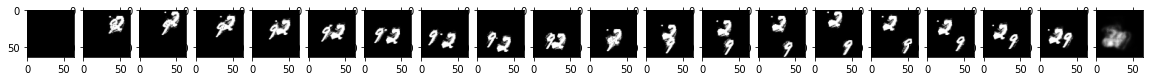

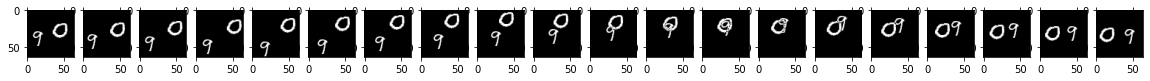

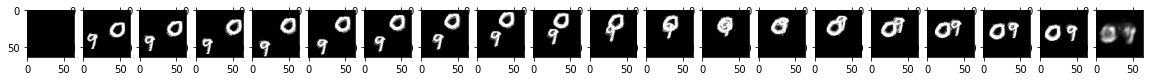

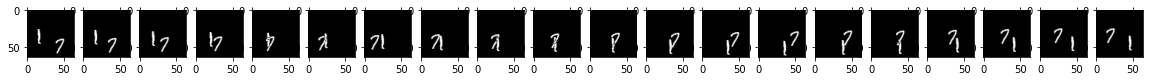

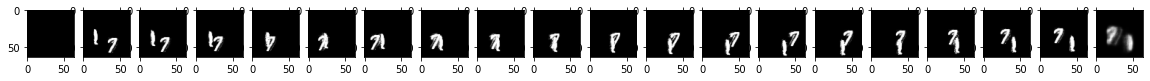

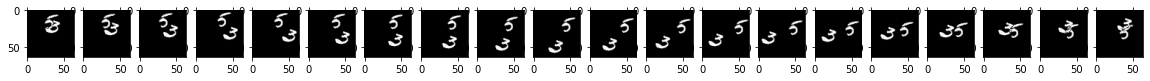

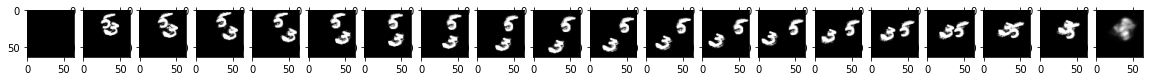

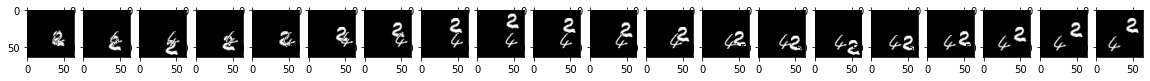

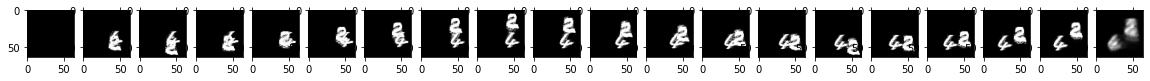

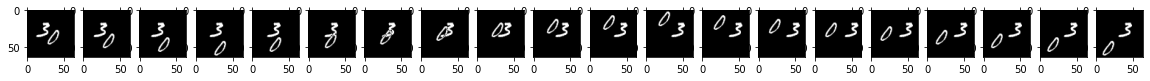

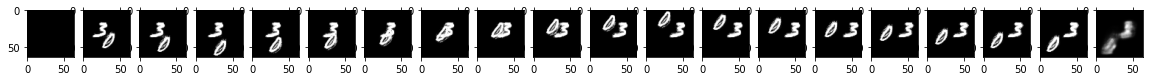

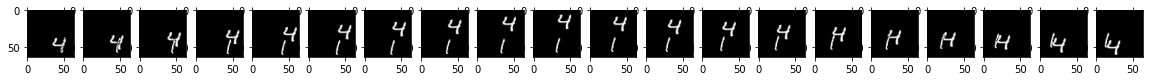

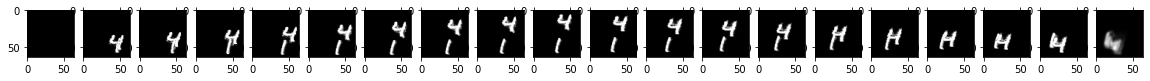

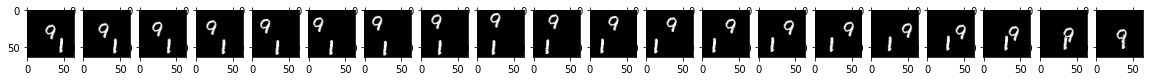

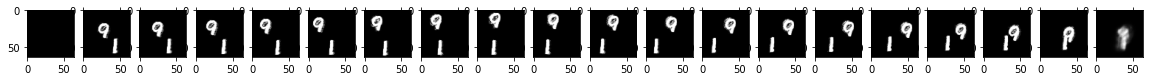

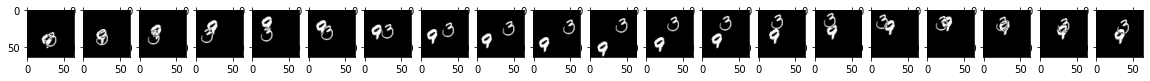

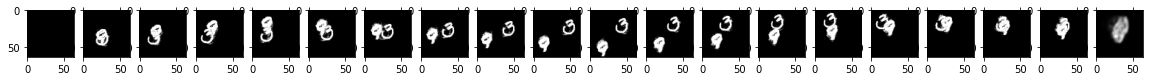

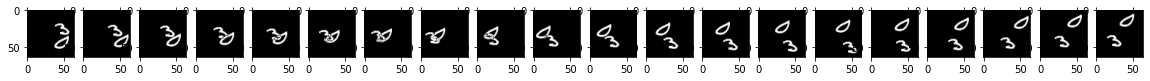

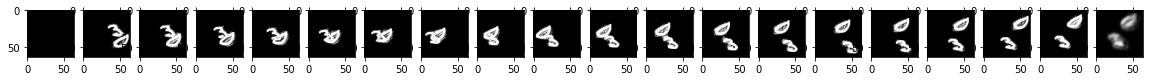

In [9]:
for sequence in range(15):
    track = x_te[sequence, :20, ::, ::, ::]
    y_prediction = seq.predict(track[np.newaxis])
    #print(y_prediction.shape)
    # ground truth
    plt.figure(figsize=(20,10))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:,0], cmap='gray')

    # prediction
    plt.figure(figsize=(20,10))
    plt.subplot(1,20,1)
    plt.imshow(np.zeros((64,64)), cmap='gray')
    for i in range(19):
        plt.subplot(1, 20, i+2) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[0,i,:,:,0], cmap='gray')

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32

y_prediction = seq.predict(x_te[:, :20, ::, ::, ::])
te_set = img_as_float32(te_set)
batch_size=1000
mse_total=0
mae_total=0
ssim_total=0

mse=0
mae=0
ssim_v=0

for i in range(batch_size):
  for j in range(19):
    mse_total += mean_squared_error(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0])
    mae_total += mean_absolute_error(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0])
    ssim_total += ssim(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0],data_range=y_prediction[i,j,:,:,0].max() - y_prediction[i,j,:,:,0].min())

mse = mse_total/(batch_size*19)
mae = mae_total/(batch_size*19)
ssim_v = ssim_total/(batch_size*19)
print('MSE: ',mse)
print('MAE: ',mae)
print('SSIM: ',ssim_v)

MSE:  0.017094053460236052
MAE:  0.03482114515002621
SSIM:  0.8612670952667526
